In [1]:
import sys
import matplotlib.pyplot as plt
from contextualbandits import online as cb
from copy import deepcopy as clone
import numpy as np
import pandas as pd
# The only classifiers that have partial_fit
# See: https://scikit-learn.org/0.15/modules/scaling_strategies.html
from sklearn.linear_model import SGDClassifier, PassiveAggressiveClassifier, Perceptron
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
sys.path.append("../src")

%matplotlib inline
from wrappers import *

In [2]:
df = pd.read_csv("../data/data.csv")

df = df.query("placementType=='banner' and bidPrice<2 and bidPrice>0.1").sample(frac=0.02)

# Read data & preprocess

In [3]:
def keep_values_by_min_freq(df, col, freq=0.9,other="OTHER"):
    ds = df[col].value_counts(normalize=True).cumsum()
    mapped2other = []
    marked_as_other = False
    for val, prop in ds.iteritems():
        if marked_as_other:
            mapped2other.append(val)
        if prop>freq:
            marked_as_other=True
    df.loc[df[col].isin(mapped2other), col]=other
    df[col] = df[col].astype('category')
    
    return df

In [4]:
def preprocess(df):
    df = df.drop("sessionId", axis=1)
    df["eventTimestamp"] = pd.to_datetime(df["eventTimestamp"]*1_000_000)
    df["day_of_week"]=df["eventTimestamp"].dt.weekday.astype("category")
    df["time_of_day"]=df["eventTimestamp"].dt.hour.astype("category")
    df.sort_values(by='eventTimestamp', inplace=True)    
    df = df.drop("eventTimestamp", axis=1)
    for col, dtype in df.dtypes.iteritems():
        if str(dtype) == 'object':
            df = keep_values_by_min_freq(df, col)
    
    df = keep_values_by_min_freq(df, 'adNetworkId')
    df = keep_values_by_min_freq(df, 'userTrackingAuth')
    
    # a, r, X for models
    df["arms"] = df["bidPrice"].round(2)
    arms = sorted(list(df["arms"].unique()))
    df["arms"] = df.apply(lambda row: [a for a in arms if a>=row["arms"]] if row["hasWon"] else
                          [a for a in arms if a<=row["arms"]],axis=1)
    df = df.explode("arms")
    arm_dict = {a:i for i, a in enumerate(arms)}
    a = df["arms"].map(arm_dict)
    r = df["hasWon"]
    df = df.drop(["bidPrice", "hasWon", "arms", "advertisedBundle"] ,axis=1)
    
    X = pd.get_dummies(df)
    
    return arm_dict, X, a, r

def preprocess_only_one_feature(df, feature='size'):
    # preprocess
    df = df[['bidPrice', 'hasWon', feature]]
    df["arms"] = df["bidPrice"].round(1)
    arms = sorted(list(df["arms"].unique()))
    df["arms"] = df.apply(lambda row: [a for a in arms if a>=row["arms"]] if row["hasWon"] else
                          [a for a in arms if a<=row["arms"]],axis=1)
    df = df.explode("arms")
    arm_dict = {a:i for i, a in enumerate(arms)}
    a = df["arms"].map(arm_dict)
    r = df["hasWon"]
    df = df.drop(["bidPrice", "hasWon", "arms"] ,axis=1)
    X = pd.get_dummies(df)
    
    return arm_dict, X, a, r


# sample
### Note for arms - we should know in advance, per each context, what is the maximum bid
# e.g. for iOS, size=320x50, plc=Banner, we should know that 10 is the maximum and not create an arm for X>10...
# Maybe - it should be calculated every X days (1 day...)

# df = df.query("placementType=='banner' and bidPrice<1.01").drop("placementType",axis=1)
df.drop("placementType", axis=1)

# X, a, r = preprocess(df)
arm_dict, X, a, r = preprocess_only_one_feature(df)

/home/daniel/.local/lib/python3.6/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/daniel/.local/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# Contextual bandits

In [5]:
class ModelWithDesiredWinRate(BernoulliNB):
    def predict_proba(self, X):
        probs = super().predict_proba(X)[:, 1] # predict proba as of any predict_proba model classifier
        y = 1 / np.abs(probs - desired_win_rate + 0.0001) # Numerical stability
        c = 1e-3
        y = 1 - np.exp(-y*c) # Normalize
        ret = np.vstack((1-y, y)).T

        return ret

In [6]:
n_arms = len(arm_dict)
bids = {v:k for k,v in arm_dict.items()}
# base_model = SGDClassifierWithNormalization(loss='log')
base_model = ModelWithDesiredWinRate()
# base_model = BernoulliNB()
desired_win_rate=0.9
logreg_sg = cb.SeparateClassifiers(clone(base_model), n_arms, batch_train=True)

In [7]:
logreg_sg.partial_fit(X,a,r)
print(type(logreg_sg._oracles.algos[0]))
assert type(base_model) == type(logreg_sg._oracles.algos[0])

# model.partial_fit(XX, aa, rr)
# [m.coef_ for m in model._oracles.algos]

<class '__main__.ModelWithDesiredWinRate'>


In [8]:
# logreg_sg.fit(X,a,r)
# [m.coef_ for m in logreg_sg._oracles.algos]

In [9]:
def simulate(model, X, a , r, chunk = 100, limit=100):
    X,a,r=map(clone,[X,a,r]) # copy the existing data so we won't change it
    
    ### TODO: Update reward with neighbor arms
    
    train_X, train_a, train_r = X.iloc[:chunk,:], a[:chunk], r[:chunk] 
    # split the data into train
    # Get chunk data points for first input
    X, a, r = X.iloc[chunk:,:], a[chunk:], r[chunk:]
    test_X, test_a, test_r = X.iloc[:chunk,:], a[:chunk], r[:chunk]
    n_iterations = 1
    regrets = []
    
    while len(X)>chunk:
        model.partial_fit(train_X,train_a,train_r)
        pred_bids = model.predict(test_X)
        regrets.append(np.sum([np.abs(bids[i]-y) for i,y in zip(pred_bids,test_r.values)])/chunk)
        train_X, train_a, train_r    = X.iloc[:chunk,:], a[:chunk], r[:chunk]
        X, a, r = X.iloc[chunk:,:], a[chunk:], r[chunk:]
        test_X, test_a, test_r = X.iloc[:chunk,:], a[:chunk], r[:chunk]
        n_iterations+=1
        if limit>0 and limit<n_iterations:
            break
            
    return regrets

# plot

Text(0.5, 0, 'iterations')

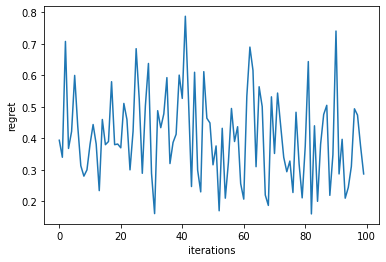

In [10]:
regret = simulate(logreg_sg, X, a, r)
plt.plot(np.arange(len(regret)), regret)
plt.ylabel("regret")
plt.xlabel("iterations")

In [11]:
print(X.columns)
pred = logreg_sg.predict(np.eye(3), output_score=True)
pred["bid"] = [bids[y] for y in pred['choice']]
pred

Index(['size_300x250', 'size_320x50', 'size_728x90'], dtype='object')


{'choice': array([10, 10,  7]),
 'score': array([[0.04858228],
        [0.13757283],
        [0.09197535]]),
 'bid': [1.1, 1.1, 0.8]}

In [12]:
df.groupby("placementType").agg({"bidPrice": np.mean, "sessionId": 'count'})

,bidPrice,sessionId
placementType,,
banner,0.33287,33236


In [13]:
df.pivot_table(values="bidPrice", index="size", columns="hasWon", aggfunc='mean')

hasWon,0,1
size,,
300x250,0.370967,0.493886
320x50,0.301466,0.420740
728x90,0.264293,0.391837


# Verification --to delete

In [ ]:

import numpy as np
from contextualbandits import online as cb
from sklearn.naive_bayes import BernoulliNB
n_arms = 6
# XX = np.random.randint(2, size=(100,10))
# aa =  np.random.randint(n_arms, size=(100))
# rr = np.random.randint(2, size=(100))
# XX = X.values[:10]
# aa = a.values[:10]
# rr = r.values[:10]
# aa = np.array([0.2, 0.1, 0.2, 0.1, 0.4, 1.1, 0.3, 0.5, 0.6, 0.7])
aa = np.array([1,2,3,4,5,6,7,8,9,0])
XX = np.array([[1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0]])
rr = np.array([0, 0, 1, 1, 1, 1, 1, 1, 1, 1])
n_arms = len({t for t in aa})
model = cb.SeparateClassifiers(BernoulliNB(), n_arms, batch_train=True)
model.partial_fit(XX, aa, rr)
[m.coef_ for m in model._oracles.algos]

In [ ]:
rr

In [ ]:
aa = np.array([0.2, 0.1, 0.2, 0.1, 0.4, 1.1, 0.3, 0.5, 0.6, 0.7])
XX = np.array([[0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0]])
rr = np.array([0, 0, 1, 1, 1, 1, 1, 1, 1, 1])